In [1]:
# Veasna Bun
# source dataset: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
# Models was derived from:
    ## Speech Emotion Classification using Ensemble Models with MFCC 
    ## Meera Mohan a, P. Dhanalakshmi b, R. Satheesh Kumar c
    ## https://www.sciencedirect.com/science/article/pii/S1877050923001631

In [2]:
# Step 1: Dataset and Data preprocessing

In [3]:
# Here we use a dictionary to store all the labels along with its fold path:

In [4]:
import os
# 0.
# Emotion labels dictionary
emotions = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprise"
}

def preprocess_labels(folder_path="dataset"):
    # Dictionary to store the path of each gender-emotion combination
    emotion_label = {}
    # Iterate over each folder in the dataset directory
    for folder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, folder)
        # Check if the folder is a directory and follows the expected naming pattern
        if os.path.isdir(subfolder_path) and "_" in folder:
            actor_info = folder.split('_')
            # Extract actor number and determine gender
            try:
                actor_number = int(actor_info[-1])
                gender = "" if actor_number % 2 == 1 else ""
            except ValueError:
                continue  # Skip this folder if it does not contain a valid actor number
            # Iterate over each file in the subfolder
            for filename in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, filename)
                identifiers = filename.split('-')
                # Check if the filename has enough identifiers to extract emotion
                if len(identifiers) > 2:
                    emotion_code = identifiers[2]
                    # Map the emotion code to the corresponding emotion label
                    emotion = emotions.get(emotion_code, None)
                    if emotion:
                        key = gender + emotion
                        # Append the file path to the list for this key
                        file_path = os.path.join(subfolder_path, filename)
                        if key in emotion_label:
                            emotion_label[key].append(file_path)
                        else:
                            emotion_label[key] = [file_path]
    return emotion_label

# Get the emotion labels
emotion_label = preprocess_labels()
# Print out our labels
import pandas as pd
# Convert the dictionary to a DataFrame
df = pd.DataFrame([(key, len(value)) for key, value in emotion_label.items()], columns=['Label', 'Count'])
# Print the DataFrame
print(df.to_string(index=False))

   Label  Count
 neutral     96
    calm    192
   happy    192
     sad    192
   angry    192
 fearful    192
 disgust    192
surprise    192


In [5]:
# Here we will process the data: we first get the raw data from its location using the dictionary we build
# extract the audio:
## where audio of the raw file is not change, 
## where audio rate is increase
## where audio pitch is increase
# we then create segment of each audio to ensure same length:
# then these segments are pass into the MFCC extraction block
# see process_dataset function

In [6]:
import os
import librosa
import numpy as np
import copy

def segment_audio(audio, segment_length=2.5, offset=0.5, sr=44100):
    # Calculate the number of samples per segment
    segment_samples = int(segment_length * sr)
    # Calculate the total number of segments
    num_segments = int(np.ceil(len(audio) / segment_samples))
    # Split the audio into segments
    audio_segments = []
    for i in range(num_segments):
        start_sample = i * segment_samples
        end_sample = start_sample + segment_samples
        segment = audio[start_sample:end_sample]
        # If the last segment is shorter, pad it with zeros
        if len(segment) < segment_samples:
            padding = segment_samples - len(segment)
            segment = np.pad(segment, (0, padding), mode='constant')
        audio_segments.append(segment)
    return audio_segments

def extract_mfcc(audio_segments, sr=44100, n_mfcc=30, n_fft=2048, hop_length=512):
    mfcc_features = []
    for segment in audio_segments:
        segment = librosa.resample(segment, orig_sr=sr, target_sr=44100, res_type='kaiser_fast')
        # Extract MFCCs from each segment
        mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfcc_features.append(mfcc)
    return mfcc_features


def process_dataset(dataset):
    X = []
    y = []
    for label, paths in dataset.items():
        print(f"Processing Label: {label}")
        #gender, emotion = label.split('_')
        for path in paths:
            # Extract the original audio
            original_audio, _ = librosa.load(path, sr=None)

            # Augment audio
            pitch_increase = librosa.effects.pitch_shift(original_audio, sr=44100, n_steps=2)
            pitch_decrease = librosa.effects.pitch_shift(original_audio, sr=44100, n_steps=-2)
            faster = librosa.effects.time_stretch(original_audio, rate=1.1)
            slower = librosa.effects.time_stretch(original_audio, rate=0.9)

            # Segment the original and augmented audio
            segments = segment_audio(original_audio)
            faster_segments = segment_audio(faster)
            slower_segments = segment_audio(slower)
            increase_segments = segment_audio(pitch_increase)
            decrease__segments = segment_audio(pitch_decrease)
            
            # Extract MFCC for original and augmented segments
            all_segments = [
                segments, 
                increase_segments,
                decrease__segments,
                faster_segments, 
                slower_segments
            ]

            for segment_list in all_segments:
                mfcc_segments = extract_mfcc(segment_list)
                for mfcc in mfcc_segments:
                    X.append(mfcc.T[..., np.newaxis])
                    y.append(label)
    
    return np.array(X), np.array(y)

# Example usage
X, y = process_dataset(emotion_label)
print(X.shape)
print(y.shape)

Processing Label: neutral
Processing Label: calm
Processing Label: happy
Processing Label: sad
Processing Label: angry
Processing Label: fearful
Processing Label: disgust
Processing Label: surprise
(7200, 216, 30, 1)
(7200,)


In [7]:
# Step 2: Training and Testing

In [8]:
# we first need to split our data into training and test
# the y is where our label reside and we will need to change them into encoder
# print to verify our test and training set

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Initialize and fit the LabelEncoder on the full label set
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Print shapes to verify
print("Training data shape:", X_train.shape)    # Should be (N_train, 30, 216, 1)
print("Training labels shape:", y_train.shape)  # Should be (N_train,)
print("Testing data shape:", X_test.shape)      # Should be (N_test, 30, 216, 1)
print("Testing labels shape:", y_test.shape)    # Should be (N_test,)


Training data shape: (5760, 216, 30, 1)
Training labels shape: (5760,)
Testing data shape: (1440, 216, 30, 1)
Testing labels shape: (1440,)


In [10]:
# Step 3: Classification Model: Deep Convolitional Model (2D-CNN)

In [11]:
# convolutional model consists of four two-dimensional convolutional blocks:
    ## including the convolutional layer, batch normalization, and pooling
    ## input size for the model is (N X 30 X 216 X 1)
    ## where N is the number of input samples; 
    ## 30 is the number of mfcc dimensions; 
    ## 216 is the number of frames per sample, 
    ## and 1 is the channel depth per sample

# Each layer of 32 Convolution kernels of size (3 X 3)
    # Stride has a fixed size of (1 X 1)
    # Each Block is associated with batch normalization to speed up the training process
    # To avoid overfitting, dropout were applied to each block with a value = 0.2
    # Relu activation was applied to each layer and 
    # The number of parameter got reduced by the Max Pooling laye

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense

def create_2d_cnn_model(input_shape=(30, 216, 1), num_classes=16):
    model = Sequential()
    # Convolutional Block 1
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    # Convolutional Block 2
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    # Convolutional Block 3
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    # Convolutional Block 4
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    # Fully Connected layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    # 2D - CNN model was compiled with Adam optimizer, with learning rate of = 0.001
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create and summarize the model
cnn_model = create_2d_cnn_model()
cnn_model.summary()

# Train the model
history = cnn_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2, 
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")



C:\Users\Veasna Bun\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 216, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 216, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 108, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 108, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 15, 108, 32)         │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 15, 108, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 54, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 54, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 54, 32)           │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 54, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 27, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 27, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 27, 32)           │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 3, 27, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 13, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 13, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          53,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 84,016 (328.19 KB)

 Trainable params: 83,760 (327.19 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step - accuracy: 0.1925 - loss: 2.5506 - val_accuracy: 0.3151 - val_loss: 1.8153
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.2956 - loss: 1.8377 - val_accuracy: 0.2587 - val_loss: 1.8273
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.3683 - loss: 1.6556 - val_accuracy: 0.3316 - val_loss: 1.6593
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.4294 - loss: 1.5345 - val_accuracy: 0.3142 - val_loss: 1.9398
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.4669 - loss: 1.4076 - val_accuracy: 0.2509 - val_loss: 2.4341
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.4912 - loss: 1.3431 - val_accuracy: 0.2925 - val_loss: 2.4126
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.5052 - loss: 1.2963 - val_accuracy: 0.3212 - val_loss: 2.1903
Epoch 8/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.5475 - loss: 1.2129

In [13]:
# write to Readme text file
# Model Summary
Summary = []
cnn_model.summary(print_fn=lambda x: Summary.append(x))
Summary = "\n".join(Summary)
# Write results to file
with open('Readme.txt', 'a', encoding='utf-8') as f:
    # Model Summary
    f.write("\n\nClassification Model: Deep Convolitional Model (2D-CNN)\n")
    f.write(f"======================================================\n") 
    f.write(f"{Summary} \n")
    # Epoch Results
    f.write("Epoch Results:\n")
    for epoch in range(len(history.history['accuracy'])):
        f.write(f"  Epoch {epoch+1}/{100} \n")
        f.write(f"    Accuracy: {history.history['accuracy'][epoch]} - Loss: {history.history['loss'][epoch]}\n")

    f.write(f"Test loss: {test_loss}\n")
    f.write(f"Test accuracy: {test_accuracy}\n")

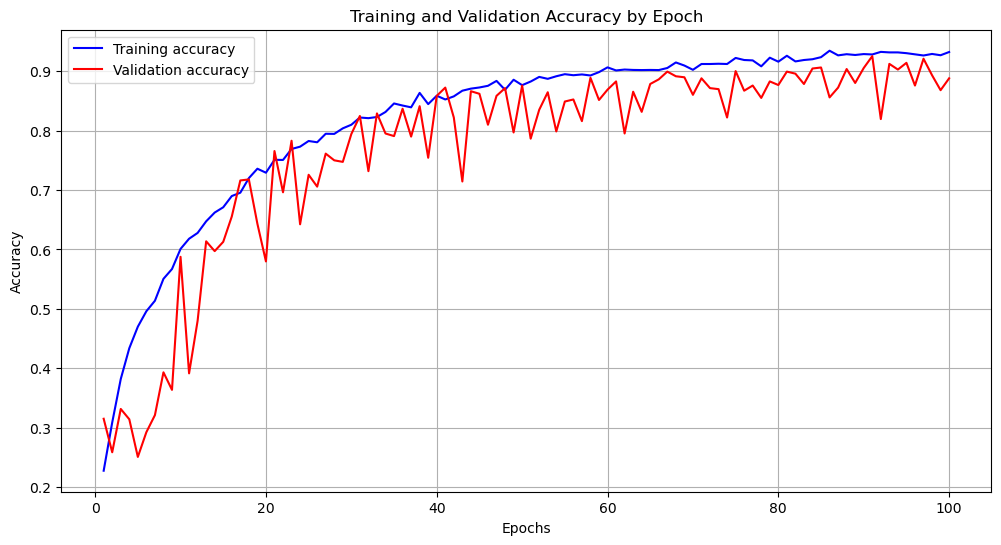

In [14]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy
epochs = range(1, len(history.history['accuracy']) + 1)
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy by Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Step 4: XG Boost Model
# predicted output from 2D-CNN is fed to XG-Boost classifer as DMatrix

In [16]:
import tensorflow as tf
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score


# Extract features from CNN
features_train = cnn_model.predict(X_train)
features_test = cnn_model.predict(X_test)

# Convert features to XGBoost DMatrix format
dtrain = xgb.DMatrix(features_train, label=y_train)
dtest = xgb.DMatrix(features_test, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'multi:softmax',
    'num_class': 8,
    'booster': 'gbtree',
    'eta': 0.2,
    'max_depth': 7,
    'eval_metric': 'merror',
}

# Train the XGBoost model
num_boost_round = 150
xgb_model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

# Make predictions with XGBoost and evaluate
y_pred = xgb_model.predict(dtest)

# Save the XGBoost model to a file
xgb_model.save_model('xgb_model.bin')

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy with XGBoost: {accuracy}")


180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Test accuracy with XGBoost: 0.9076388888888889


C:\Users\Veasna Bun\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [23:19:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [17]:
# write xbg model to text file
with open('Readme.txt', 'a', encoding='utf-8') as f:
    f.write("\n\nXGBoost Model Summary\n")
    f.write(f"======================================================\n") 
    
    # Write XGBoost parameters
    f.write("Model Parameters:\n")
    for param, value in params.items():
        f.write(f"{param}: {value}\n")
    
    f.write(f"\nNumber of boosting rounds (epochs): {num_boost_round}\n")
    
    # Write feature importance
    importance = xgb_model.get_score(importance_type='weight')
    f.write("\nFeature Importance (by weight):\n")
    for feature, score in importance.items():
        f.write(f"{feature}: {score}\n")
    
    # Write test accuracy
    f.write(f"\nTest accuracy with XGBoost: {accuracy}\n")

In [18]:
# Step 5: Predict Sentiments 
# we will be using the_lion_king.wav that is already formated with the following properties
# 16 bits, 44.1 kHz .wav

In [19]:
import xgboost as xgb
import numpy as np
import librosa
from sklearn.decomposition import PCA

def extract_features_from_audio(file_path):
    audio, _ = librosa.load(file_path, sr=44100)
    segments = segment_audio(audio)
    # Extract MFCC features from each segment
    mfcc_features = extract_mfcc(segments)
    # Flatten the MFCC features
    mfcc_features = [np.array(mfcc).flatten() for mfcc in mfcc_features]
    mfcc_features = np.array(mfcc_features)
    # Reduce dimensions if necessary
    pca = PCA(n_components=8) 
    mfcc_features = pca.fit_transform(mfcc_features)
    return mfcc_features

# Load the XGBoost model
xgb_model = xgb.Booster()
xgb_model.load_model('xgb_model.bin')

# Define a function to predict with XGBoost
def predict_from_audio(file_path):
    # Extract features from the audio file
    features = extract_features_from_audio(file_path)
    if features.shape[1] != 8:
        raise ValueError("Feature dimensions do not match the expected input.")
    # Convert features to XGBoost DMatrix format
    dmatrix = xgb.DMatrix(features)
    # Predict
    prediction = xgb_model.predict(dmatrix)
    return prediction

# Example usage
file_path = 'the_lion_king.wav'
predictions = predict_from_audio(file_path)

# this will be use to keep track of the audio at a curtain sec,
# where an gender_emotion was prediced from the audio
sr = 44100
audio, _ = librosa.load(file_path, sr=sr, duration=None)
duration = len(audio) / sr
scene = duration / len(predictions)
sec = 0


with open("Readme.txt", "a", encoding='utf-8') as f:
    f.write(f"\n\nPREDICTION FOR THE AUDIO: {file_path.upper()} \n")
    f.write(f"Total Duration {duration:.2f} seconds\n")
    f.write(f"======================================================\n") 
    sec = 0  # Initialize the sec variable
    for prediction in predictions:
        # Integer value representing the class
        encoded_value = int(prediction) 
        # Get the class labels
        class_labels = label_encoder.classes_
        # Map the integer to the original class label
        original_label = class_labels[encoded_value]
        #gender, emotion = original_label.split('_')
        
        f.write(f"Time-Stamp start: {sec:.2f}/{duration:.2f} seconds\n")
        sec += scene
        f.write(f"Time-Stamp end: {sec:.2f}/{duration:.2f} seconds\n")
        f.write(f"The emotion predicted: {original_label}\n\n")